## Clustering Model: Model with Product Category

Set up a basic pipeline using **standardized preprocessing from preprocess.py** and distilbert.

## 🔧 Steps:
1. Import Libraries and load data using **preprocess.py functions**
2. Preprocessing: refer data_preprocessing.ipynb notebook
3. Vectorization: TF-IDF Vectorization
4. Model: K-Means clustering on Review
5. Evaluation: Clustering

##  ✅ Purpose:
Establish a working pipeline using **standardized preprocessing functions** and maintain baseline score (~70-80% accuracy expected).

## Load Libraries

In [62]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from wordcloud import WordCloud
import seaborn as sns
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mercy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Step 1: Load the Cleaned data

In [63]:
df = pd.read_csv('data/cleaned_amazon_reviews_final.csv')
print(df.head())
print(df.info())

                                                name       asins   brand  \
0  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
1  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
2  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
3  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
4  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   

                                          categories primaryCategories  \
0  Computers,Electronics Features,Tablets,Electro...       Electronics   
1  Computers,Electronics Features,Tablets,Electro...       Electronics   
2  Computers,Electronics Features,Tablets,Electro...       Electronics   
3  Computers,Electronics Features,Tablets,Electro...       Electronics   
4  Computers,Electronics Features,Tablets,Electro...       Electronics   

                                           imageURLs  doRecommend  rating  \
0  https://pisces.bby

## Step 2: Preprocess and Vectorize text using TF-IDF

In [64]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, min_df=5)
X = vectorizer.fit_transform(df['clean_text'])
print(f"TF-IDF Matrix Shape: {X.shape}")

TF-IDF Matrix Shape: (4385, 1354)


## Step 3: K-Means Elbow Method

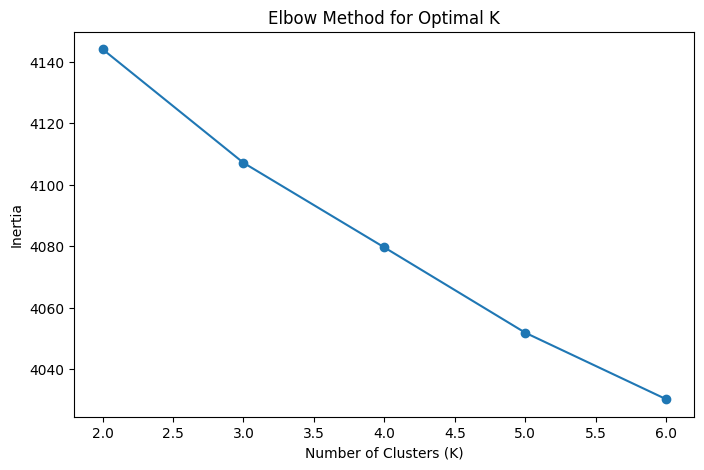

Inertia values:
K=2: Inertia=4144.122256046017
K=3: Inertia=4107.127781607401
K=4: Inertia=4079.5805589551974
K=5: Inertia=4051.8070913783813
K=6: Inertia=4030.163343480869


In [65]:
def elbow_method(X, k_range):
    inertias = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    return k_range, inertias

k_range = range(2, 7) 
k_values, inertias = elbow_method(X, k_range)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

print("Inertia values:")
for k, inertia in zip(k_values, inertias):
    print(f"K={k}: Inertia={inertia}")

## Step 4: K-Means Silhouette Score

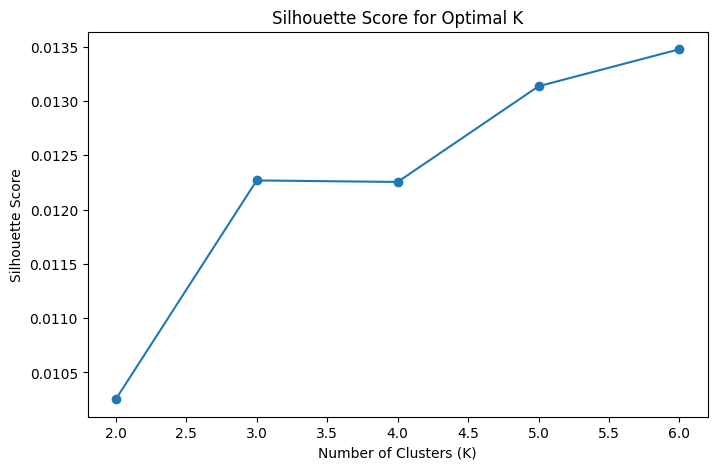

Silhouette Scores:
K=2: Silhouette Score=0.010253184636622508
K=3: Silhouette Score=0.012269066803569725
K=4: Silhouette Score=0.01225490248565984
K=5: Silhouette Score=0.013136743287924846
K=6: Silhouette Score=0.013477819400810434


In [66]:
def silhouette_analysis(X, k_range):
    silhouette_scores = []
    valid_k = []
    for k in k_range:
        if k == 1:
            continue
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(X)
        score = silhouette_score(X, cluster_labels)
        silhouette_scores.append(score)
        valid_k.append(k)
    return valid_k, silhouette_scores

k_range = range(2, 7)  
valid_k, silhouette_scores = silhouette_analysis(X, k_range)

plt.figure(figsize=(8, 5))
plt.plot(valid_k, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

print("Silhouette Scores:")
for k, score in zip(valid_k, silhouette_scores):
    print(f"K={k}: Silhouette Score={score}")

 ## Step 5: K-Means Clustering

Optimal K based on Silhouette Score: 6
cluster
4    1719
0     910
2     503
3     457
1     408
5     388
Name: count, dtype: int64


C:\Users\Mercy\AppData\Local\Temp\ipykernel_11684\3872459658.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=df, palette='viridis')


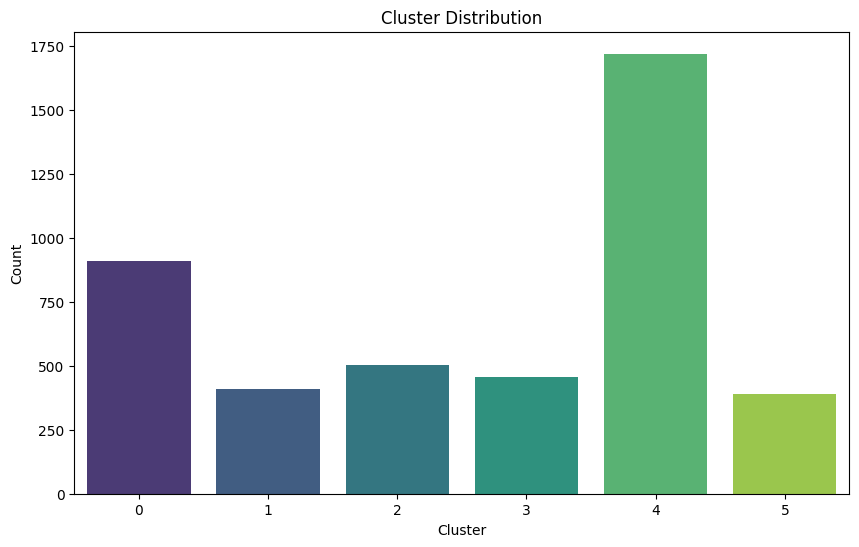

In [67]:
optimal_k = max(valid_k, key=lambda k: silhouette_scores[k-2]) 
print(f"Optimal K based on Silhouette Score: {optimal_k}")
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X)
df['cluster'] = kmeans.labels_
print(df['cluster'].value_counts())
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df, palette='viridis')
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

## 5.1: Top Words per Cluster

In [68]:
def get_top_terms_per_cluster(kmeans_model, vectorizer, n_terms=10):
    terms = vectorizer.get_feature_names_out()
    top_words = {}
    for i, center in enumerate(kmeans_model.cluster_centers_):
        top_indices = center.argsort()[::-1][:n_terms]
        top_words[i] = [terms[i] for i in top_indices]
    return top_words

In [69]:
from collections import Counter

def top_words_by_cluster(df, cluster_col='cluster', text_col='clean_text', top_n=10):
    cluster_words = {}
    for c in sorted(df[cluster_col].unique()):
        words = ' '.join(df[df[cluster_col] == c][text_col]).split()
        common = Counter(words).most_common(top_n)
        cluster_words[c] = [word for word, _ in common]
    return cluster_words

top_words = top_words_by_cluster(df)
for cluster_id, words in top_words.items():
    print(f"Cluster {cluster_id}: {', '.join(words)}")

Cluster 0: tablet, for, the, it, great, and, a, to, i, is
Cluster 1: for, it, a, gift, and, my, love, the, this, i
Cluster 2: to, great, and, easy, it, product, use, the, for, a
Cluster 3: the, i, kindle, it, and, to, a, my, is, for
Cluster 4: the, it, to, i, and, a, for, is, my, this
Cluster 5: the, alexa, to, and, i, it, a, is, my, love


## Step 6: Analyze Clusters

In [70]:
cluster_counts = df['cluster'].value_counts().sort_index()
print(cluster_counts)

for cluster_id in range(optimal_k):
    print(f"Cluster {cluster_id}:")
    print(df[df['cluster'] == cluster_id]['name'].sample(3))  # Display 3 random samples
    print("\n")

cluster
0     910
1     408
2     503
3     457
4    1719
5     388
Name: count, dtype: int64
Cluster 0:
4152    Brand New Amazon Kindle Fire 16gb 7" Ips Displ...
1927    Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...
4206    Brand New Amazon Kindle Fire 16gb 7" Ips Displ...
Name: name, dtype: object


Cluster 1:
4060    Brand New Amazon Kindle Fire 16gb 7" Ips Displ...
358     Amazon Echo Show Alexa-enabled Bluetooth Speak...
3501    All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi...
Name: name, dtype: object


Cluster 2:
1505    Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...
1196          Amazon - Echo Plus w/ Built-In Hub - Silver
1295          Amazon - Echo Plus w/ Built-In Hub - Silver
Name: name, dtype: object


Cluster 3:
3900    All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi...
4328    All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi...
1873    Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...
Name: name, dtype: object


Cluster 4:
3582    All-New Fire HD 8 Tablet, 8" HD Dis

## Step 7: Visualize Clusters

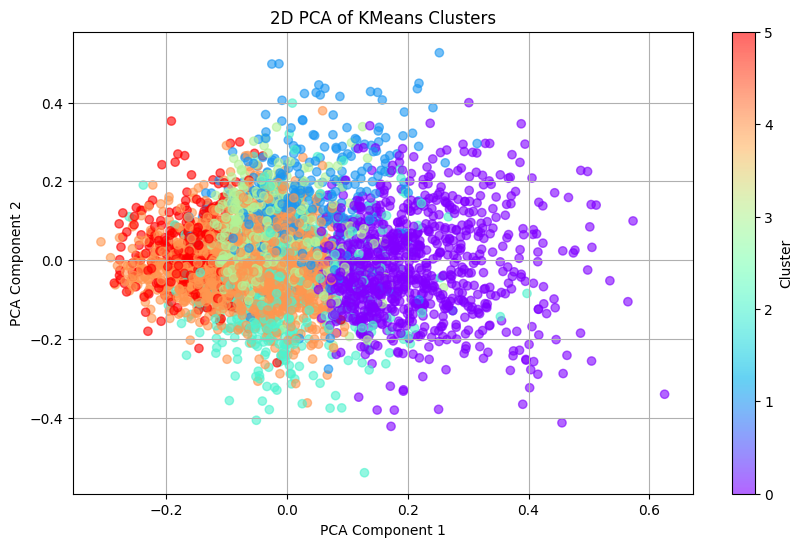

In [71]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=df['cluster'], cmap='rainbow', alpha=0.6)
plt.title('2D PCA of KMeans Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

C:\Users\Mercy\AppData\Local\Temp\ipykernel_11684\776771506.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=df, palette='Set2')


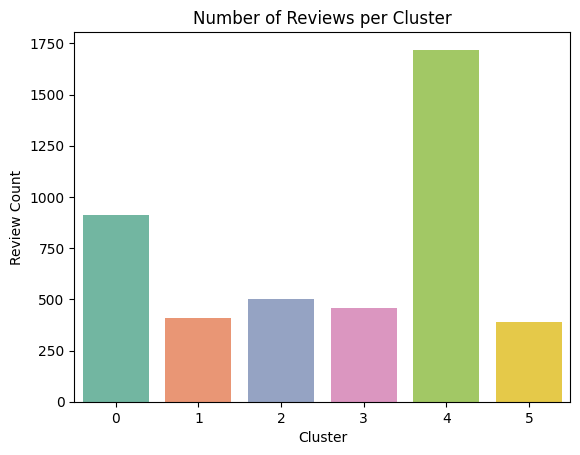

In [72]:
sns.countplot(x='cluster', data=df, palette='Set2')
plt.title('Number of Reviews per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Review Count')
plt.show()

## 7.1: Sentiment Analysis Per Cluster
Analyze the sentiment (positive, negative, neutral) within each cluster to understand the emotional tone of reviews.

* what are we achieving:
    * Proportion of positive (rating ≥ 4), neutral (rating = 3), and negative (rating ≤ 2) reviews per cluster.
    * Average rating per cluster to identify which clusters contain more favorable reviews.


Sentiment Distribution per Cluster (Proportion):
 sentiment  Negative   Neutral  Positive
cluster                                
0          0.007692  0.041758  0.950549
1          0.004902  0.012255  0.982843
2          0.003976  0.015905  0.980119
3          0.013129  0.026258  0.960613
4          0.043630  0.058755  0.897615
5          0.007732  0.028351  0.963918

Average Rating per Cluster:
 cluster
0    4.600000
1    4.732843
2    4.747515
3    4.704595
4    4.484002
5    4.703608
Name: rating, dtype: float64


<Figure size 1000x600 with 0 Axes>

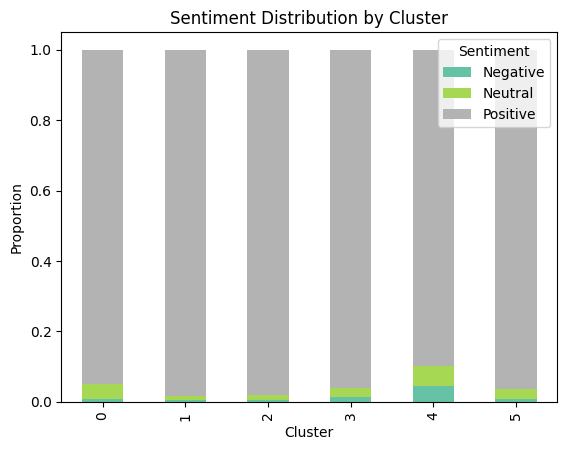

In [73]:
def analyze_cluster_sentiment(df):
    df['sentiment'] = df['rating'].apply(lambda x: 'Positive' if x >= 4 else 'Negative' if x <= 2 else 'Neutral')
    sentiment_dist = df.groupby('cluster')['sentiment'].value_counts(normalize=True).unstack().fillna(0)
    print("\nSentiment Distribution per Cluster (Proportion):\n", sentiment_dist)
    avg_rating = df.groupby('cluster')['rating'].mean()
    print("\nAverage Rating per Cluster:\n", avg_rating)
    
    plt.figure(figsize=(10, 6))
    sentiment_dist.plot(kind='bar', stacked=True, colormap='Set2')
    plt.title('Sentiment Distribution by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Proportion')
    plt.legend(title='Sentiment')
    plt.show()

analyze_cluster_sentiment(df)

## 7.2: Top Products per Cluster
Identify the most representative products in each cluster by grouping reviews by product name and counting occurrences or aggregating ratings.

* What are we achieving:
    * Top 3–5 products per cluster based on review count or average rating.
    * Example reviews for these products to provide context.

In [74]:
def top_products_per_cluster(df, n=3):
    for cluster in df['cluster'].unique():
        cluster_df = df[df['cluster'] == cluster]
        top_products = cluster_df.groupby('name').agg({
            'rating': ['count', 'mean'],
            'clean_text': lambda x: list(x)[:2] 
        }).reset_index()
        top_products.columns = ['name', 'review_count', 'avg_rating', 'sample_reviews']
        top_products = top_products.sort_values(by='review_count', ascending=False).head(n)
        print(f"\nTop {n} Products in Cluster {cluster}:\n")
        print(top_products[['name', 'review_count', 'avg_rating']])
        print("\nSample Reviews:")
        for idx, row in top_products.iterrows():
            print(f"\nProduct: {row['name']}")
            for review in row['sample_reviews']:
                print(f"- {review}")

top_products_per_cluster(df)


Top 3 Products in Cluster 3:

                                                 name  review_count  \
2   All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi...           102   
7           Amazon - Kindle Voyage - 6" - 4GB - Black            47   
11  Brand New Amazon Kindle Fire 16gb 7" Ips Displ...            44   

    avg_rating  
2     4.725490  
7     4.702128  
11    4.886364  

Sample Reviews:

Product: All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta
- great picture quality this wa bought to replace my old kindle with keypad and experimental internet wa surprised how much the kindle had changed and at the same price a my old one wa when i bought ithave already shown it to a couple of friend who now say they are thinking about getting one
- kindle fire hd outstanding replacement tablet for my outdated and overpriced ipad

Product: Amazon - Kindle Voyage - 6" - 4GB - Black
- great ereader no complaint i had an older version of a kindle ereader

## 7.3: Word Clouds for Clusters
Word clouds based on TF-IDF weights or raw term frequencies for each cluster.

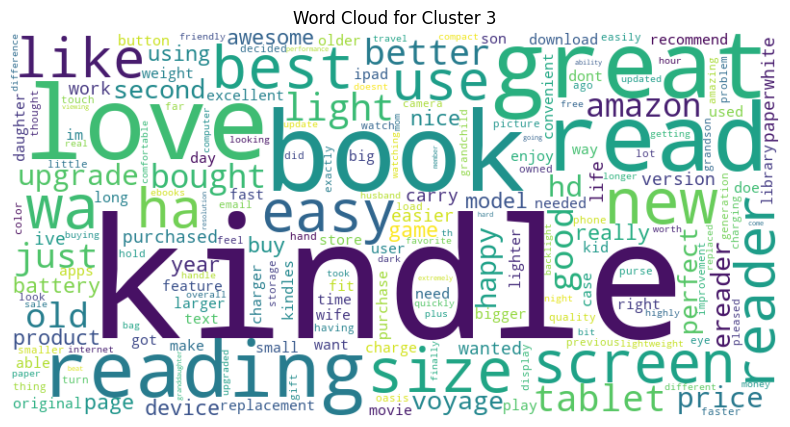

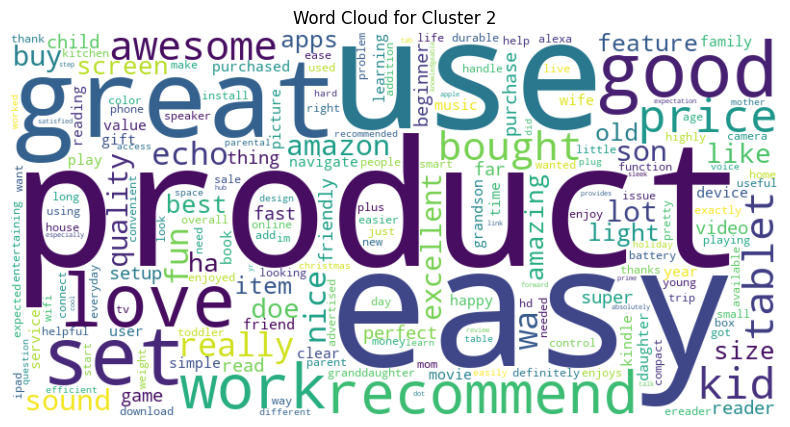

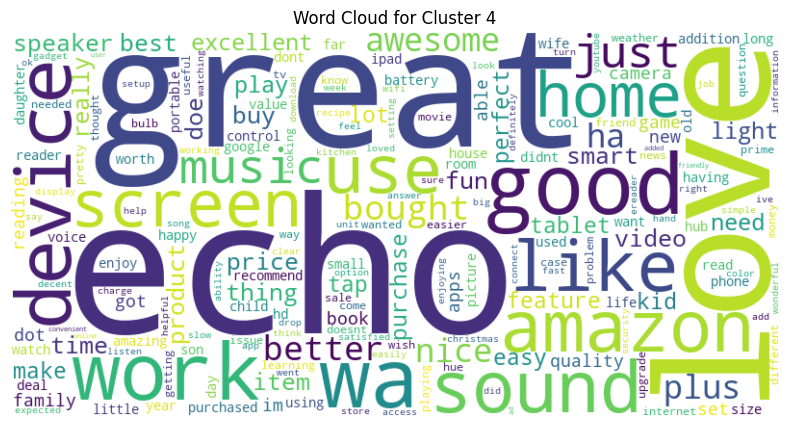

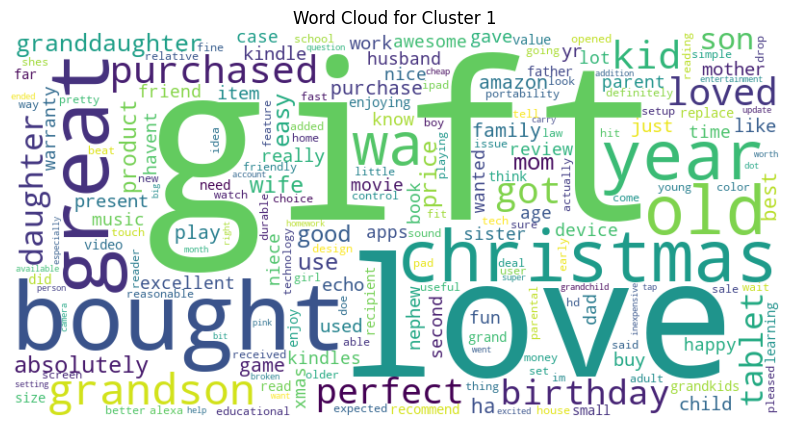

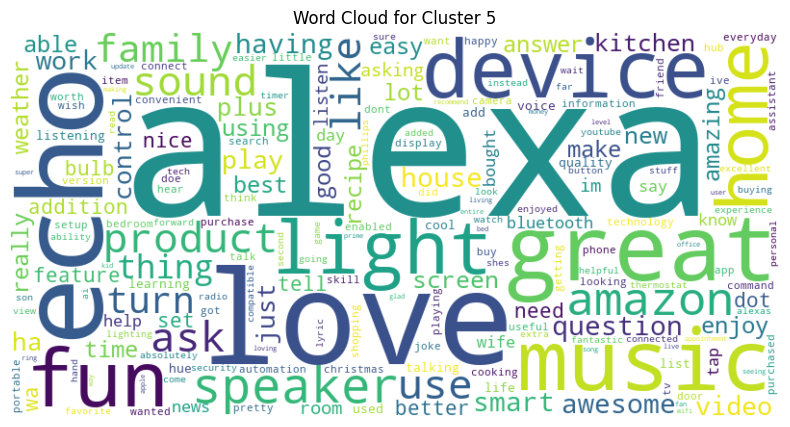

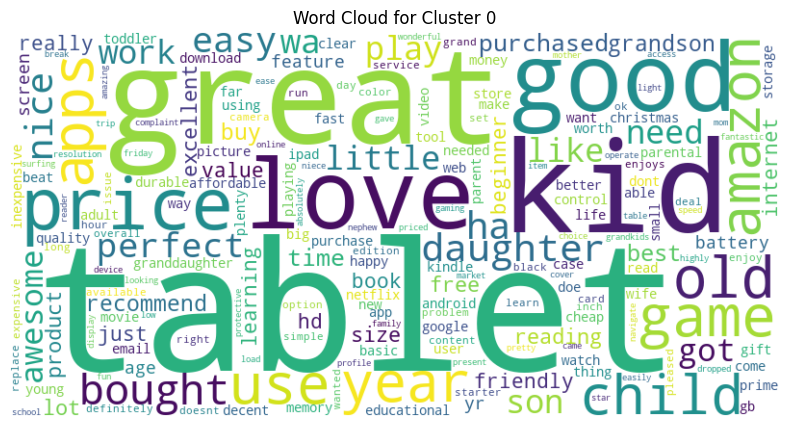

In [75]:
def plot_word_clouds(df, vectorizer, X):
    feature_names = vectorizer.get_feature_names_out()
    for cluster in df['cluster'].unique():
        cluster_indices = df[df['cluster'] == cluster].index
        cluster_tfidf = X[cluster_indices].sum(axis=0).A1  # Sum TF-IDF scores
        word_scores = dict(zip(feature_names, cluster_tfidf))
        
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_scores)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for Cluster {cluster}')
        plt.axis('off')
        plt.show()

plot_word_clouds(df, vectorizer, X)

## 7.4: Product Categories
Validation distribution of primaryCategories (e.g., Electronics, Hardware) across clusters and whether clusters align with primaryCategories or categories.


Primary Categories Distribution per Cluster (Proportion):
 primaryCategories  Electronics  Electronics,Hardware  Electronics,Media  \
cluster                                                                   
0                     0.982418              0.000000           0.000000   
1                     0.740196              0.230392           0.004902   
2                     0.584493              0.349901           0.001988   
3                     0.803063              0.002188           0.032823   
4                     0.529959              0.425247           0.003490   
5                     0.126289              0.873711           0.000000   

primaryCategories  Office Supplies,Electronics  
cluster                                         
0                                     0.017582  
1                                     0.024510  
2                                     0.063618  
3                                     0.161926  
4                                     0.04130

<Figure size 1200x600 with 0 Axes>

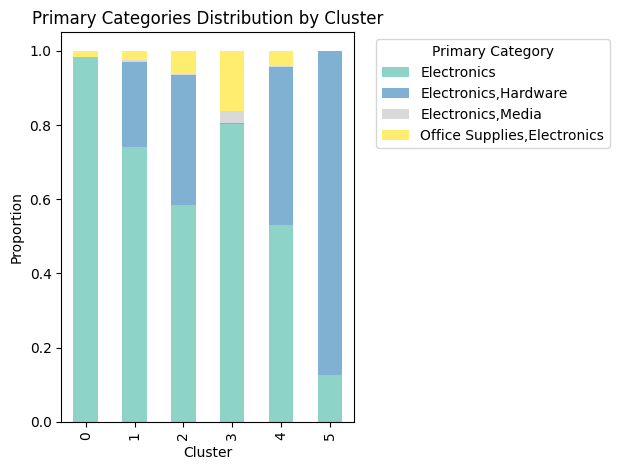

In [76]:
def analyze_categories_per_cluster(df):
    category_dist = df.groupby('cluster')['primaryCategories'].value_counts(normalize=True).unstack().fillna(0)
    print("\nPrimary Categories Distribution per Cluster (Proportion):\n", category_dist)
    plt.figure(figsize=(12, 6))
    category_dist.plot(kind='bar', stacked=True, colormap='Set3')
    plt.title('Primary Categories Distribution by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Proportion')
    plt.legend(title='Primary Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

analyze_categories_per_cluster(df)

## 7.5: Hierarchical Clustering
Using hierarchical clustering to create a dendrogram and explore how reviews group at different levels.

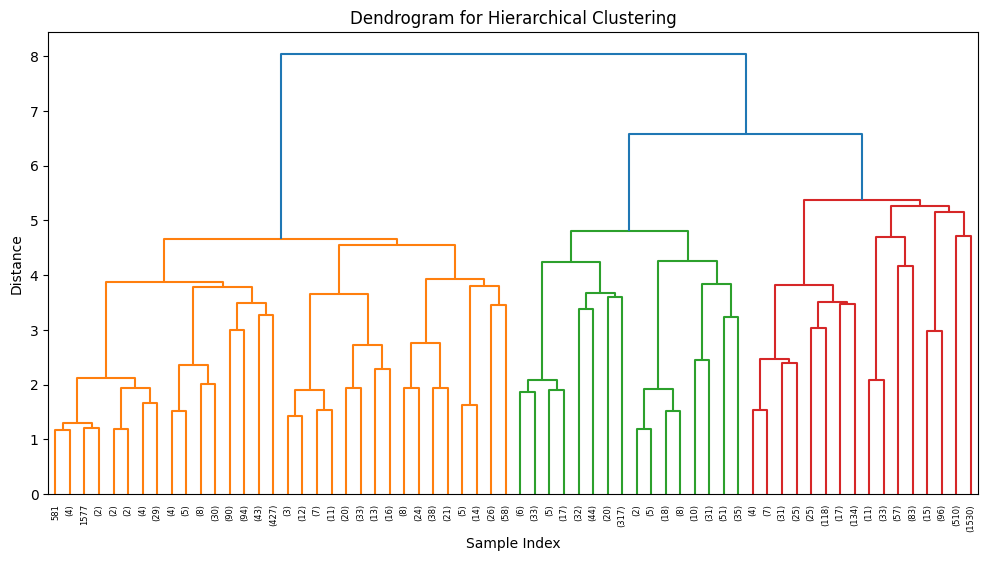


Hierarchical Cluster Distribution:
 cluster_hierarchical
0    2151
4    1055
2     634
3     361
1     184
Name: count, dtype: int64


In [77]:
Z = linkage(X.toarray(), method='ward')
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()
hierarchical = AgglomerativeClustering(n_clusters=5)
df['cluster_hierarchical'] = hierarchical.fit_predict(X.toarray())
print("\nHierarchical Cluster Distribution:\n", df['cluster_hierarchical'].value_counts())

## 7.6: DBSCAN 
identify clusters of arbitrary shape and detecting outliers

In [78]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['cluster_dbscan'] = dbscan.fit_predict(X)
print("\nDBSCAN Cluster Distribution (including noise):\n", df['cluster_dbscan'].value_counts())
noise_reviews = df[df['cluster_dbscan'] == -1]
print("\nSample Noise Reviews (if any):")
print(noise_reviews[['name', 'clean_text', 'rating']].head())


DBSCAN Cluster Distribution (including noise):
 cluster_dbscan
-1    4385
Name: count, dtype: int64

Sample Noise Reviews (if any):
                                                name  \
0  Amazon Kindle E-Reader 6" Wifi (8th Generation...   
1  Amazon Kindle E-Reader 6" Wifi (8th Generation...   
2  Amazon Kindle E-Reader 6" Wifi (8th Generation...   
3  Amazon Kindle E-Reader 6" Wifi (8th Generation...   
4  Amazon Kindle E-Reader 6" Wifi (8th Generation...   

                                          clean_text  rating  
0  too small i thought it would be a big a small ...       3  
1  great light reader easy to use at the beach th...       5  
2  great for the price didnt know how much id use...       4  
3  a great buy i am happy with my purchase i caug...       5  
4  solid entrylevel kindle great for kid solid en...       5  


## 7.7: Cluster Size Comparision
Creating a pie chart to show the proportion of reviews in each cluster.

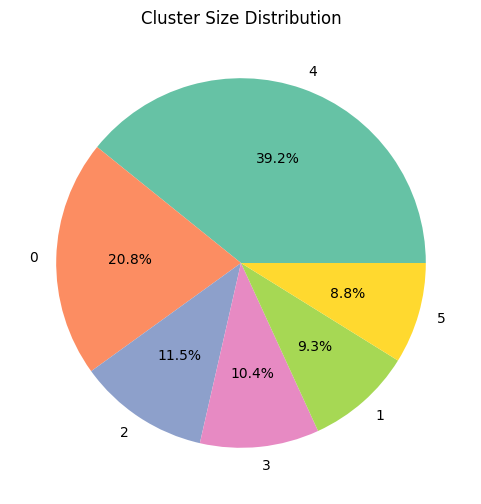

In [79]:
cluster_counts = df['cluster'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('Cluster Size Distribution')
plt.show()

## Step 8: Product Evaluations

## 8.1: Product Recommendations 
Using cluster information to recommend products based on positive reviews within clusters.

In [80]:
def recommend_products(df, n=3):
    recommendations = []
    for cluster in df['cluster'].unique():
        cluster_df = df[df['cluster'] == cluster]
        top_products = cluster_df.groupby('name')['rating'].mean().nlargest(n).reset_index()
        recommendations.append((cluster, top_products))
        print(f"\nTop {n} Recommended Products in Cluster {cluster}:\n", top_products)
    return recommendations

recommendations = recommend_products(df)


Top 3 Recommended Products in Cluster 3:
                                                 name  rating
0  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...     5.0
1  All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi...     5.0
2        Amazon - Echo Plus w/ Built-In Hub - Silver     5.0

Top 3 Recommended Products in Cluster 2:
                                                 name  rating
0  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...     5.0
1  All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi...     5.0
2  Amazon - Kindle Voyage - 4GB - Wi-Fi + 3G - Black     5.0

Top 3 Recommended Products in Cluster 4:
                                                 name    rating
0  Amazon Fire TV with 4K Ultra HD and Alexa Voic...  5.000000
1  Kindle Oasis E-reader with Leather Charging Co...  4.909091
2  All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi...  4.833333

Top 3 Recommended Products in Cluster 1:
                                                 name  rating
0  Amazon - Kindle Voyage -

## 8.2: Customer Pain Points
Identifying common complaints in low-rated reviews within each cluster.

In [81]:
def analyze_negative_reviews(df, vectorizer, X):
    negative_df = df[df['rating'] <= 2]
    feature_names = vectorizer.get_feature_names_out()
    for cluster in negative_df['cluster'].unique():
        cluster_neg = negative_df[negative_df['cluster'] == cluster]
        cluster_indices = cluster_neg.index.tolist()
        if len(cluster_indices) == 0:
            continue
        cluster_tfidf = X[cluster_indices].sum(axis=0).A1
        cluster_tfidf = cluster_tfidf[:len(feature_names)]
        top_terms = pd.Series(cluster_tfidf, index=feature_names).nlargest(5)
        print(f"\nTop Terms in Negative Reviews for Cluster {cluster}:\n", top_terms)
        print("\nSample Negative Reviews:")
        print(cluster_neg['clean_text'].head(2))

analyze_negative_reviews(df, vectorizer, X)


Top Terms in Negative Reviews for Cluster 4:
 wa          4.160533
slow        3.059401
returned    2.462088
apps        2.385992
buy         2.368916
dtype: float64

Sample Negative Reviews:
20    tricked into buying i wa looking for a kindle ...
70    dont bother looking at the picture and seeing ...
Name: clean_text, dtype: object

Top Terms in Negative Reviews for Cluster 5:
 program    0.687555
money      0.565460
alexa      0.501903
limited    0.443805
echo       0.411378
dtype: float64

Sample Negative Reviews:
355    alexa echo not a very responsive program very ...
514    useless screen so why pay for it worthless exc...
Name: clean_text, dtype: object

Top Terms in Negative Reviews for Cluster 2:
 returned       0.838531
support        0.444671
instruction    0.430205
product        0.406416
hard           0.391050
dtype: float64

Sample Negative Reviews:
1315    returned returned product cause i did not like...
2827    not a good product hard to use and doe not sup...
Name:

## 8.3: Top 5 Best products

In [82]:
sorted_df = df.sort_values(by=["rating", "text"], ascending=[False, False])
unique_best = sorted_df.drop_duplicates(subset="name", keep="first")
best_products = unique_best.head(5)

In [43]:
for _, row in best_products.iterrows():
    print(f"Image URL: {row['imageURLs']}")
    print(f"Product Name: {row['name']}")
    print(f"Review: {row['clean_text']}")
    print(f"Rating: {row['rating']}")
    print(f"Primary Categories: {row['primaryCategories']}")
    print("-" * 40)

def process_review(image_url, review, rating):
    print(f"Processing: {image_url}, {review}, {rating}")

Image URL: http://i.ebayimg.com/thumbs/images/g/3MIAAOSwol5Y4W6z/s-l96.jpg,https://pisces.bbystatic.com/image2/BestBuy_US/images/products/5023/5023200_sa.jpg,http://i.ebayimg.com/thumbs/images/g/amcAAOSw6ShZSpke/s-l200.jpg,http://i.ebayimg.com/thumbs/images/g/PJgAAOSwiDFYPE8h/s-l200.jpg,http://i.ebayimg.com/thumbs/images/g/TPQAAOSwHb9Zcih6/s-l96.jpg,https://pisces.bbystatic.com/image2/BestBuy_US/images/products/5023/5023200_sd.jpg,http://i.ebayimg.com/thumbs/images/g/J4EAAOSw4CFYnSS8/s-l200.jpg,http://i.ebayimg.com/thumbs/images/g/LFQAAOSw1BlZWfTe/s-l200.jpg,http://images.frys.com/art/product/box_shots/8819902.box.GIF,http://i.ebayimg.com/thumbs/images/g/KO8AAOSw8GtZUbHj/s-l200.jpg,http://i.ebayimg.com/images/g/wv8AAOSw0W1ZjNVZ/s-l64.jpg,http://i.ebayimg.com/thumbs/images/g/I6UAAOSw-0xYc7VD/s-l200.jpg,http://i.ebayimg.com/thumbs/images/g/TPQAAOSwHb9Zcih6/s-l200.jpg,http://i.ebayimg.com/thumbs/images/g/fIMAAOSwlMFZN7Zq/s-l200.jpg,http://i.ebayimg.com/images/g/sVAAAOSwH6tZjNVW/s-l64.jpg,

## 8.4: Worst Product

In [83]:
worst_product = df.sort_values(by='label', ascending=True).head(1)

print("\nWorst Product:")
for index, row in worst_product.iterrows():
    print(f"Image URL: {row['imageURLs']}")
    print(f"Product Name: {row['name']}")
    print(f"Review: {row['clean_text']}")
    print(f"Rating: {row['rating']}")
    print(f"Primary Categories: {row['primaryCategories']}")
    print("-" * 40)

def process_review(image_url, review, rating):
    print(f"Processing: {image_url}, {review}, {rating}")


Worst Product:
Image URL: https://static.bhphoto.com/images/images500x500/amazon_b010cehqtg_echo_show_white_1502460407000_1353417.jpg,https://c1.neweggimages.com/NeweggImage/ProductImage/81-511-001-V01.jpg,https://i5.walmartimages.com/asr/5638a5f1-ac87-4f19-a40a-1c8f97667060_1.eb5a3b378540fee9c3df5c656a718cd9.jpeg%252525253FodnHeight%252525253D450%2525252526odnWidth%252525253D450%2525252526odnBg%252525253DFFFFFF,https://i5.walmartimages.com/asr/db02a974-11af-4de9-b228-c36426eb2b44_1.22c5de2dd319a4ae3a2f23548c464eb1.jpeg%252525253FodnHeight%252525253D450%2525252526odnWidth%252525253D450%2525252526odnBg%252525253DFFFFFF,https://static.bhphoto.com/images/images500x500/amazon_echo_show_2_pack_white_1506004002000_1353763.jpg,https://www.barcodable.com/images/barcode/0848719084894.png,https://c1.neweggimages.com/NeweggImage/ProductImage/81-511-001-V02.jpg,https://c1.neweggimages.com/NeweggImage/ProductImage/81-511-001-Z01.jpg,https://images-na.ssl-images-amazon.com/images/I/51YHTHvHapL.jpg,